# Assignment 5 – Machine Learning Fashionista 2.0
**`SVM vs VGG16` | `Machine Learning vs. Deep Learning`**

### 1. Problem Definition

The aim of this project is to compare the performance of a machine learning model (SVM) to a deep learning model (VGG16) in classifying/differentiating between **`jerseys`** and **`shirts`**.
\
\
Here, the classification problem can really be defined as distinguishing between **`jersey`** and **`non-jersey`** shirts. Hence, in the **`shirts`** dataset, we have a variety from the broader class of shirts such as T-shirts, blouses, etc., but no **`jerseys`** – this is ensured in the cleaning phase discussed below. The **`jersey`** dataset, on the otherhand, contains to a high degree of confidence, only jerseys. Here a jersey is taken to mean shirts worn specifically for sporting activities such as football or basketball.

### 2. Data Extraction & Cleaning Discussion
The original datasets were obtained from ImageNet as per the assignment prompt. However, the datasets were very messy and had significant overlap (e.g. multiple jerseys in the **`shirts`** dataset and multiple corporate shirts in the **`jersey`** data). As these would pose significant difficulty for a future classifier to model on, I manually scanned through both datasets and performed the following operations:

- Moving images to their correct datasets (e.g. moving images of jerseys from **`shirts`** to **`jerseys`**)
- Deleting images that contained both shirts and jerseys, etc. - it would be hard to assign a class to these
- Deleting images that had nothing to do with the relevant classes (jerseys or shirts)

Following this procedure, the **`jersey`** dataset was left very sparse. Hence, I extracted more jersey images from Google images using a Google Chrome extension called [Image downloader - Imageye](https://chrome.google.com/webstore/detail/image-downloader-imageye/agionbommeaifngbhincahgmoflcikhm). To do so, queries along the lines of **`jersey football`** or **`jersey basketball`** were searched for. The resulting **`jerseys`** dataset following this extraction procedure had about 250 images.

Despite this data curation step, there was still a huge imbalance between both classes. This is addressed below:

### 3. Library Importation

In [ ]:
#Image loading and manipulation libraries
from glob import glob
from PIL import Image, ImageOps
from resizeimage import resizeimage

#Libraries for machine learning modeling
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

#Libraries for VGG16 modeling
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout

#Libraries for plotting and data manipulation
import numpy as np
import matplotlib.pyplot as plt

### 4. Split the data into training and test sets

#### a. Connect to the data path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dir_path = '/content/gdrive/MyDrive/Colab Notebooks/CS156'

In [ ]:
shirt_paths = glob(f'{dir_path}/shirts/*.JPEG')
jersey_paths = glob(f'{dir_path}/jerseys/*.JPEG')

print(f"Shirts dataset size: {len(shirt_paths)}")
print(f"Jersey dataset size: {len(jersey_paths)}")


Shirts dataset size: 560
Jersey dataset size: 257


Due to the imbalance (as shown above), I restrict both classes to have 100 images each in the test set. 
\
\
To get closer to balancing the training set (which clearly is still very imbalanced), I only use a subset of the shirt images (300 specifically). However, this still leaves some imbalance. 
\
\
Hence, I perform data augmentation on the jersey images in the training set to balance up both classes. Asides improving class imbalance, data augmentation could also reduce overfitting and improve model performance (Wong et. al., 2016).

#### b. Allocate 100 images per class to the test set

In [ ]:
#GET TEST SET INDICES
#Randomly select 100 images per class for the test set
shirt_test_idx = np.random.choice(len(shirt_paths),100,replace=False)
jersey_test_idx = np.random.choice(len(jersey_paths),100, replace=False)

#### c. Allocate 300 images from the shirts class to the training set

In [ ]:
#Get indices of all possible shirt images
all_shirt_img_idx = np.array([*range(len(shirt_paths))])

#Note all the shirts that were assigned to the test set
shirt_in_test = np.isin(all_shirt_img_idx,shirt_test_idx)

#Randomly pick 300 shirts that are not in the test set
shirt_train_idx = np.random.choice(all_shirt_img_idx[~shirt_in_test], 
                                   300, 
                                   replace=False)


#### d. Allocate the remaining jersey images (about 150) to the training set

In [ ]:
#Get indices of all possible jersey images
all_jersey_img_idx = np.array([*range(len(jersey_paths))])

#Note all the jerseys that were assigned to the test set
jersey_in_test = np.isin(all_jersey_img_idx,jersey_test_idx)

#Get all jersey images that are not in the test set
jersey_train_idx = all_jersey_img_idx[~jersey_in_test]


In [ ]:
print('Training set size')
print(f" Jersey: {len(jersey_train_idx)} Shirts: {len(shirt_train_idx)}",'\n')
print('Test set size')
print(f" Jersey: {len(jersey_test_idx)} Shirts: {len(shirt_test_idx)}")

Training set size
 Jersey: 157 Shirts: 300 

Test set size
 Jersey: 100 Shirts: 100


### 5. Define function to load & preprocess the images

In [ ]:
def load_and_preprocess_imgs(class_imgs, class_label, augment_data = False):

  #List to store all the flattened images
  flattened_imgs = []

  #Size to resize images to
  img_size = [400,400]

  #Random data augmentation processes
  #Vertical and horizontal flip, respectively.
  augmentations = {0:(lambda x: ImageOps.flip(x)), 
                   1:(lambda x: ImageOps.mirror(x))}

  #For each image path
  for path in class_imgs:
      
      #Open it as a read file in binary mode
      with open(path, 'r+b') as f:
          
          #Open it as an image
          with Image.open(f) as image:
              
              #Check if the image is too small
              if min(image.size) < min(img_size):
                  
                  #If it is, enlarge to the img_size
                  cover = image.resize(img_size)
                  
              else:
                  #Resize the image to be more manageable
                  cover = resizeimage.resize_cover(image, img_size)

              #If data augmentation was passed as True
              if augment_data:

                #Also perform random data augmentation
                augmented_img = augmentations[np.random.choice([0,1])](cover)

                #Flatten augmented image to array and add to list
                flattened_imgs.append((np.array(augmented_img).flatten(),
                                      class_label))

                  
              #Flatten the original image's matrix to an array and append it 
              #to all flattened images list
              flattened_imgs.append((np.array(cover).flatten(),
                                    class_label))
          
  #Flatten once more
  flattened_imgs = np.asarray(flattened_imgs)

  return flattened_imgs



### 6. Load & preprocess the images

#### a. For training set

In [ ]:
#CREATE TRAINING SET

#1. Generate the flattened shirt and jersey images
#Here we also encode/label each image. 0 for jersey and 1 for shirt
shirt_train = load_and_preprocess_imgs([shirt_paths[i] for i in shirt_train_idx],1)
jersey_train = load_and_preprocess_imgs([jersey_paths[i] for i in jersey_train_idx],0,True)

#2. Merge both datasets
merged_train = np.concatenate([shirt_train,jersey_train])

#3. Shuffle the merged array 
merged_train_shuffled = merged_train.copy()
np.random.default_rng().shuffle(merged_train_shuffled)
      
#4. Split into images and labels
X_train = np.stack(i for i in merged_train_shuffled[:,0])
y_train = np.stack(i for i in merged_train_shuffled[:,1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
print(X_train.shape)
print(y_train.shape)

(614, 480000)
(614,)


#### b. For test set
**Note**: We only augment the training set. Not the test set!

In [ ]:
#CREATE TEST SET

#1. Generate the flattened shirt and jersey images
#Here we also encode/label each image. 0 for jersey and 1 for shirt
shirt_test = load_and_preprocess_imgs([shirt_paths[i] for i in shirt_test_idx],1)
jersey_test = load_and_preprocess_imgs([jersey_paths[i] for i in jersey_test_idx],0)

#2. Merge both datasets
merged_test = np.concatenate([shirt_test,jersey_test])

#3. Shuffle the merged array
merged_test_shuffled = merged_test.copy()
np.random.default_rng().shuffle(merged_test_shuffled)
      
#4. Split into images and labels
X_test = np.stack(i for i in merged_test_shuffled[:,0])
y_test = np.stack(i for i in merged_test_shuffled[:,1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
print(X_test.shape)
print(y_test.shape)

(200, 480000)
(200,)


In [ ]:
#Save arrays in case of a crash or something lol
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

### 7. Data Exploration
**`Visualizing some of the images`**

**Jerseys**

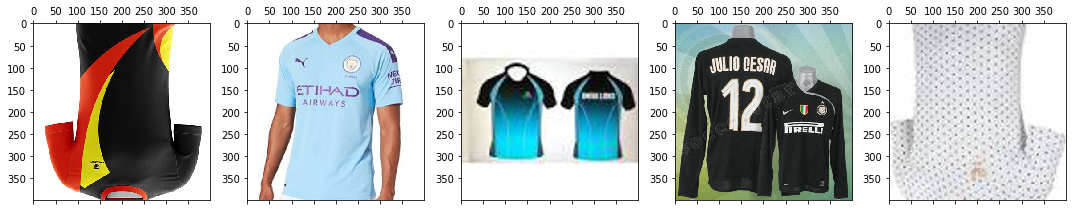

In [ ]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(np.argwhere(y_train==0).flatten(),5)):
    plt.subplot(1,5,idx+1).matshow(X_train[img].reshape((400,400,3)))
plt.tight_layout()
plt.show()

We see some of the augmented images above: the flipped ones

**Shirts (i.e. Non-jerseys)**

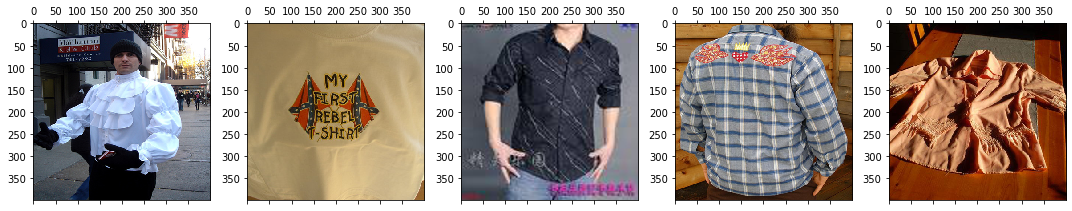

In [ ]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(np.argwhere(y_train==1).flatten(),5)):
    plt.subplot(1,5,idx+1).matshow(X_train[img].reshape((400,400,3)))
plt.tight_layout()
plt.show()

---
## Using Machine Learning Models For Image Classification
Ideally, I would conduct a grid search to determine the optimal hyperparameters for e.g. the regularization parameter. However, I was constrained on time. Hence, I use the default parameters.

### 8. Modeling: Linear SVC

In [ ]:
#Initialize linear svc model
linear_clf = LinearSVC()

#Fit on the original data
linear_clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

#### a. Computing error rate

**Training set**

In [ ]:
linear_train_acc_score = linear_clf.score(X_train,y_train)
linear_train_error = 1 - linear_train_acc_score
print(f"Train set error rate: {linear_train_error}")

Train set error rate: 0.0


**Test set**

In [ ]:
linear_test_acc_score = linear_clf.score(X_test,y_test)
linear_test_error = 1 - linear_test_acc_score
print(f"Test set error rate: {linear_test_error}")

Test set error rate: 0.28


We see clear evidence of overfitting as the model predicts perfectly on the training set but has a 28% error on the test set. This could likely be improved by increasing regularization (manipulating the *C* parameter). However I don't think it would improve performance too much because we are still fitting a linear model to data that is most certainly non-linear.

#### b. Classification report & confusion matrix

In [ ]:
#Predict on the test data
linear_y_preds = linear_clf.predict(X_test)
print(classification_report(y_test, linear_y_preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.74      0.68      0.71       100
      shirts       0.70      0.76      0.73       100

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



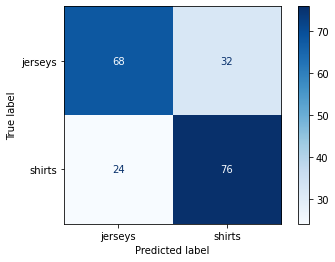

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,linear_y_preds, 
                                        display_labels=['jerseys','shirts'],
                                        cmap = 'Blues')  
plt.show() 

Objectively speaking, the results on the test set are not extremely bad. 70% is pretty good. However, can we do better? Especially by introducing some non-linearity into our model? More SVM kernels are explored below:

### 9. Modeling: Polynomial SVC (Degree 2)

In [ ]:
#Initialize polynomial SVM
poly_clf = SVC(kernel='poly', degree=2)

#Fit on the original data
poly_clf.fit(X_train,y_train)

SVC(degree=2, kernel='poly')

#### a. Computing error rate

**Training set**

In [ ]:
poly_train_acc_score = poly_clf.score(X_train,y_train)
poly_train_error = 1 - poly_train_acc_score
print(f"Train set error rate (Poly SVC): {poly_train_error}")

Train set error rate (Poly SVC): 0.032573289902280145


**Test set**

In [ ]:
poly_test_acc_score = poly_clf.score(X_test,y_test)
poly_test_error = 1 - poly_test_acc_score
print(f"Test set error rate (Poly SVC): {poly_test_error}")

Test set error rate (Poly SVC): 0.235


We see clear evidence of overfitting as the model predicts with very high accuracy (roughly 97%) on the training set but much lower accuracy on the test set (roughly 76%). Again, this could possibly be improved by increased regularization, albeit only slightly I would guess. Our model is still constrained to a quadratic kernel.
\
\
There, however, was some improvement on overfitting compared to the linear SVM.
\
\
This is most likely due to the polynomial kernel which allows the learning of non-linear models (Wikipedia, 2019). Although here, this is still constrained to a quadratic relationship– a very simplistic relationship which is unlikely to be the case with our data/decision boundary.

#### b. Classification report & confusion matrix

In [ ]:
poly_y_preds = poly_clf.predict(X_test)
print(classification_report(y_test, poly_y_preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.81      0.69      0.75       100
      shirts       0.73      0.84      0.78       100

    accuracy                           0.77       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.77      0.76       200



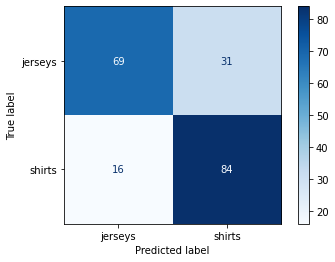

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,poly_y_preds, 
                                        display_labels=['jerseys','shirts'],
                                        cmap = 'Blues')  
plt.show() 

The model does pretty well at accurately predicting shirts. But predicts a significant number of jerseys as shirts. However, there is certainly improvement compared to the linear SVM above.

Can we do even better by increasing the model's flexibility?

### 9. Modeling: SVM with RBF kernel



In [ ]:
#Initialize SVM with RBF kernel
rbf_clf = SVC(kernel='rbf')

#Fit on the original data
rbf_clf.fit(X_train,y_train)

SVC()

#### a. Computing error rate

**Training set**

In [ ]:
rbf_train_acc_score = rbf_clf.score(X_train,y_train)
rbf_train_error = 1 - rbf_train_acc_score
print(f"Train set error rate (SVC with RBF kernel): {rbf_train_error}")

Train set error rate (SVC with RBF kernel): 0.06514657980456029


**Test set**

In [ ]:
rbf_test_acc_score = rbf_clf.score(X_test,y_test)
rbf_test_error = 1 - rbf_test_acc_score
print(f"Test set error rate (SVC with RBF kernel): {rbf_test_error}")

Test set error rate (SVC with RBF kernel): 0.18500000000000005


Similar to the above cases, the model might be overfitting the data. However, this phenomenon is certainly improved compared to the other SVMs implemented above. In this case in particular, I think increasing regularization could be valuable as the model is not as constrained as in the cases above.

If I had ample time, I would run a grid search on the regularization parameter to determine a more optimal degree of regularization.

#### b. Classification report & confusion matrix

In [ ]:
#Predict on the test data
rbf_y_preds = rbf_clf.predict(X_test)
print(classification_report(y_test, rbf_y_preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.81      0.82      0.82       100
      shirts       0.82      0.81      0.81       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



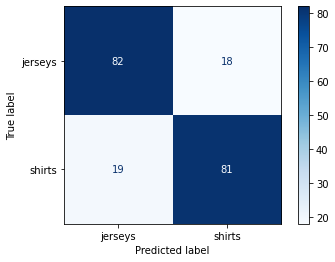

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,rbf_y_preds, 
                                        display_labels=['jerseys','shirts'],
                                        cmap = 'Blues')  
plt.show() 

Clearly, we see improved performance on the test set compared to the previous SVM models (note especially the improvement at the top right quadrant of the confusion matrix!) This is most likely due to the introduction of more non-linearity into the model, making it more flexible to fitting our non-linear data, compared to the other SVM models

---
## Using a Deep Learning Model (VGG16) for Classification




### a. Load the pretrained VGG16 model

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape = (400,400,3))

#### b. Adapt VGG16 model for our purpose

Above, we set **`include_top`** to False to drop the fully connected ouput layers, thus allowing a new output layer to be added and trained.
\
\
Subsequently, we flatten the outputs from the last convolutional layer and feed it into a dropout to drop some units during the training process (with a hope that this helps with overfitting). Finally we output a single value for the observation (as a result of the sigmoid activation at the output layer).
\
\
For training, the binary cross entropy loss function is selected because we are dealing with a binary class variable: 0 for jersey and 1 for shirt. Pairing this with the sigmoid (which returns a single value), we thus decide if an image is a jersey or a shirt using a threshold of 0.5 (jersey if value < 0.5, else a shirt) (see *section e* below).

In [ ]:
#Don't train existing weights
vgg16.trainable = False
 
#Tweak VGG16 model for our binary classification task
adapted_vgg16 = Sequential()
adapted_vgg16.add(vgg16)
adapted_vgg16.add(Flatten())
adapted_vgg16.add(Dropout(0.5))
adapted_vgg16.add(Dense(1, activation='sigmoid'))

#Get model summary
adapted_vgg16.summary()

#Compile model using binary cross entropy loss
adapted_vgg16.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 12, 512)       14714688  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dropout_3 (Dropout)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 73729     
                                                                 
Total params: 14,788,417
Trainable params: 73,729
Non-trainable params: 14,714,688
_________________________________________________________________


#### c. Reshape data to VGG16 input requirements

In [ ]:
#TRAIN DATA
#1. Images
X_train_vgg = np.array([img.reshape(400,400,3) for img in X_train])
print('Train:')
print(X_train_vgg.shape)

#2. Labels
y_train_vgg = y_train.reshape(-1, 1)
print(y_train_vgg.shape)

#TEST DATA
#1. Images
X_test_vgg = np.array([img.reshape(400,400,3) for img in X_test])
print('\n','Test:')
print(X_test_vgg.shape)

#2. Labels
y_test_vgg = y_test.reshape(-1, 1)
print(y_test_vgg.shape)

Train:
(614, 400, 400, 3)
(614, 1)

 Test:
(200, 400, 400, 3)
(200, 1)


#### d. Fit the model on the reshaped data

In [ ]:
adapted_vgg16.fit(X_train_vgg,y_train_vgg, epochs=10, batch_size=32)

Epoch 1/10
20/20 [==============================] - 979s 49s/step - loss: 2.5362 - accuracy: 0.8958
Epoch 2/10
20/20 [==============================] - 979s 49s/step - loss: 0.1879 - accuracy: 0.9805
Epoch 3/10
20/20 [==============================] - 964s 48s/step - loss: 0.2280 - accuracy: 0.9821
Epoch 4/10
20/20 [==============================] - 964s 48s/step - loss: 0.1615 - accuracy: 0.9788
Epoch 5/10
20/20 [==============================] - 971s 48s/step - loss: 0.0517 - accuracy: 0.9935
Epoch 6/10
20/20 [==============================] - 964s 48s/step - loss: 0.0575 - accuracy: 0.9951
Epoch 7/10
20/20 [==============================] - 966s 48s/step - loss: 0.0340 - accuracy: 0.9951
Epoch 8/10
20/20 [==============================] - 964s 48s/step - loss: 0.0446 - accuracy: 0.9935
Epoch 9/10
20/20 [==============================] - 968s 48s/step - loss: 0.0401 - accuracy: 0.9967
Epoch 10/10
20/20 [==============================] - 963s 48s/step - loss: 0.1370 - accuracy: 0.9902

#### e. Predict on test set



In [ ]:
#Predict on the test set
predictions = adapted_vgg16.predict(X_test_vgg)

#Convert to class labels
preds = [1 if x > 0.5 else 0 for x in predictions]

#### f. Compute accuracy and test set error

In [ ]:
#Compute accuracy and then test set error
vgg_acc_score = accuracy_score(y_test_vgg, preds)
vgg_test_error = 1 - vgg_acc_score

print(f"Test set error rate (VGG16): {vgg_test_error}")

Test set error rate (VGG16): 0.07499999999999996


The model does a really great job on the test set as we see from the test set error (7%) above. This is much lower (more than half!) than the error we obtained from all the SVM models above, which ranged from 18.5% to 28%.

In particular, overfitting is reduced compared to the previous SVM models.

#### g. Classification report and confusion matrix

In [ ]:
print(classification_report(y_test_vgg, preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.96      0.89      0.92       100
      shirts       0.90      0.96      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



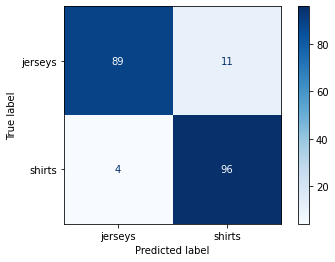

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_vgg, preds, 
                                        display_labels=['jerseys','shirts'],
                                        cmap = 'Blues')  
plt.show() 

We see really great performance on the test set. All metrics displayed above (precision, recall and accuracy), mostly in the 90% range!
\
\
Looking at the confusion matrix above, we see that the bottom left quadrant is now in the single digits (just 4 misclassifications of a jersey as a shirt! This is less than quarter of the number of misclassifications from the SVMs above).
\
\
It is important to note that here we used the pretrained VGG16 on our data. We would most likely get improved performance by fine tuning this pretrained model for our task. That way the weights are adjusted to better learn to differentiate between shirts and jerseys.

---
## Comparison
*Is there even a debate?*
\
\
From the classification and error results above, we see that the deep learning model (VGG16) is superior to the machine learning models for this image classification task.
\
\
For fairer comparison, we might compare the SVM with RBF with the VGG16 model as the other two SVM models were very constrained in terms of non-linearity and so could not account for enough non-linearity in the data. Specifically, the use of the RBF kernel allows the kernel trick to be better benefited from as the data can be projected to higher dimensions (greater than 2) to find the decision boundary.
\
\
Nonetheless, the VGG16 model is still superior, (I think) not necessarily because it is a deep network having 16 layers, but because of its background. The VGG16 implemented was pretrained on ImageNet (which has an extremely large number of classes) achieving a high degree of accuracy on the dataset. Thus, I think it was able to learn a lot of patterns and complexity from this data (some most likely even more complex than shirts and jerseys), making the task of differentiating jerseys and shirts a lot easier.
\
\
With increased training and optimization (tweaking of hyperparameters), it might be possible to significantly improve the performance of the SVM with RBF (maybe even up to the level of the VGG16 model).
\
\
It's also important to note that training the SVM has the advantage of being fast compared to the deep learning model since it only considers a small subset of the data (the support vectors) when training as against the whole training dataset.


## References
- Wong, S. C., Gatt, A., Stamatescu, V., & McDonnell, M. D. (2016, November). Understanding data augmentation for classification: when to warp?. In 2016 international conference on digital image computing: techniques and applications (DICTA) (pp. 1-6). IEEE.
- Wikipedia Contributors. (2019, October 2). Polynomial kernel. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Polynomial_kernel

‌

In [ ]:
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
#colab_pdf('CS156/Assignment5 – Machine Learning Fashionista 2.0.ipynb')